## A2: Bias in data

### Project Overview

The goal of this project is to explore the concept of 'bias' in data by analyzing Wikipedia articles on political figures from different countries.  

The data will include a dataset of political articles on Wikipedia, the predicted article quality scores for those articles, and a dataset of country populations.  

The analysis will quantify the number of Wikipedia articles devoted to politicians in each country, label the quality of those articles, and consider how those measurements vary between countries.  

The data visualization will include a series of plots that show:  
  1. The countries with the greatest and the least coverage of politicians on Wikipedia compared to their population sizes.  
  2. The countries with the highest and the lowest proportion of high quality articles about politicians.  
 

In [ ]:
"""
The code in this notebook cell is optional, you do not need to run this
    cell in order to run the code in subsequent cells, but if this cell
    isn't run, some intermediate values won't be displayed.
To run a cell, position the cursor inside the cell, so the cell border
    turns green, and simultaneously press the keys: control and return (or enter).
"""

# This code displays all results created within a jupyter notebook cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# This code displays Matplotlib objects inline.
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

## Step 1. Getting the Data

We will be combining three sources of data:  
 - the Wikipedia dataset,
 - the population dataset, and
 - the article quality prediction dataset.

### Wikipedia Dataset
The Wikipedia dataset about political articles (also called pages) can be found on [Figshare](https://figshare.com/articles/Untitled_Item/5513449). The English language article data was extracted using the Wikimedia API, saved as a CSV file named page_data.csv, and uploaded to Figshare. For more information, see the `README.md` file in this `data-512-a2` repository.  

A copy of the `page_data.csv` file is also available in this `data-512-a2` repository.   
  
The columns in the page_data.csv file are:
 1. country: the country name, extracted from the category name
 2. page: the Wikipedia page (aka article) title
 3. rev_id: the revision_id for the last edit to the page

In [24]:
"""
The code in this cell reads in the Wikipedia article data from the
    file page_data.csv to get this data:
        RangeIndex: 47197 entries, 0 to 47196
        Data columns (total 3 columns):
            page       47197 non-null object
            country    47197 non-null object
            rev_id     47197 non-null int64
            
The data is then stored in a pandas DataFrame (DF) object.
"""

import csv
import pandas as pd

page_data = pd.read_csv("page_data.csv")
page_data.head()

,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409


In [25]:
print("Number of rows and columns in page_data", page_data.shape)

Number of rows and columns in page_data (47197, 3)


In [26]:
"""
The code in this cell:
    (1) standardizes some of the country names in page_data for merging page_data
        with the population data; and 
    (2) removes two rows with revision ID values that don't exist in the dataset
        being used by the ORES API, and therefore return errors [807367030, 807367166].
"""

# Part 1: standardize country names
# COUNTRY_MAP from Gary
COUNTRY_MAP = {
    "East Timorese" : "Timor-Leste",
    "Hondura" : "Honduras",
    "Rhodesian" : "Zimbabwe",
    "Salvadoran" : "El Salvador",
    "Samoan" : "Samoa",
    "São Tomé and Príncipe" : "Sao Tome and Principe",
    "South African Republic" : "South Africa",
    "South Korean" : "Korea, South"
}

# A sample of original rows with values we want to replace
page_data.loc[page_data.index.isin([272, 443, 448, 541, 602])]

# use isin to filter for valid rows, and then use replace to replace the values

if page_data["country"].isin(COUNTRY_MAP.keys()).any():
    page_data["country"].replace(COUNTRY_MAP, inplace=True)

# Verify that the values were replaced in those sample rows
page_data.loc[page_data.index.isin([272, 443, 448, 541, 602])]


# Part 2: removal of revision ID values

# check if rev_id values in page_data
page_data.loc[page_data["rev_id"].isin([807367030, 807367166])]

# remove rows with rev_id in [807367030, 807367166]
page_data = page_data.loc[~page_data["rev_id"].isin([807367030, 807367166])]
page_data.head(10)

,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409
5,Template:Nigeria-politician-stub,Nigeria,391862819
6,Template:Colombia-politician-stub,Colombia,391863340
7,Template:Chile-politician-stub,Chile,391863361
8,Template:Fiji-politician-stub,Fiji,391863617
9,Template:Solomons-politician-stub,Solomon Islands,391863809


In [27]:
print("Ending number of rows and columns in page_data", page_data.shape)

Ending number of rows and columns in page_data (47195, 3)


### Population Dataset
The population data is on the Population Research Bureau website, download the CSV file. In this notebook, the population data CSV file is named, `Population Mid-2015.csv`.

In [15]:
"""
The code in this cell reads in the country population data from
    the file population_mid-2015.csv and does some processing.

When you read population_mid-2015.csv without any parameters
    like the page_data.csv file above, the title becomes a
    single column. So, to get 6 columns instead of 1, set the
    second row (index 1) as the header with parameter: header=1.
    
    The original data in population_mid-2015.csv looks like this:
        RangeIndex: 210 entries, 0 to 209
        Data columns (total 6 columns):
            Location         210 non-null object
            Location Type    210 non-null object
            TimeFrame        210 non-null object
            Data Type        210 non-null object
            Data             210 non-null int64
            Footnotes        0 non-null float64
"""

pop_data = pd.read_csv("population_mid-2015.csv", #skiprows=0,
                       header=1, sep=",", thousands=",")

# Only drop unneeded columns if they are in pop_data DF
if len(pop_data.columns) > 2:
    pop_data.drop(["Location Type", "TimeFrame",
                   "Data Type", "Footnotes"], axis=1, inplace=True)
else:
    pass

# Rename columns to standardize names for future merging
pop_data.rename(columns={"Location" : "country",
                         "Data" : "population"}, inplace=True)

pop_data.head()

,country,population
0,Afghanistan,32247000
1,Albania,2892000
2,Algeria,39948000
3,Andorra,78000
4,Angola,25000000


### Article Quality Prediction Dataset

The predicted quality scores for each article in the Wikipedia dataset comes from a Wikimedia API endpoint for a machine learning system called __ORES__ ("Objective Revision Evaluation Service"). ORES estimates the quality of an article at a particular point in time, and assigns a series of probabilities that the article is best described by one of the categories listed below.  

The range of quality scores are, from best to worst:   
  1.	FA - Featured article
  2.	GA - Good article
  3.	B - B-class article
  4.	C - C-class article
  5.	Start - Start-class article
  6.	Stub - Stub-class article  

These quality scores are a sub-set of quality assessment categories developed by Wikipedia editors. For more information about the scores, see [Project Assessment](https://en.wikipedia.org/wiki/Wikipedia:WikiProject_assessment#Grades).  

The ORES API documentation can be found [here](https://www.mediawiki.org/wiki/ORES) and the web API is [here](https://ores.wikimedia.org/v3/). The API requires: a revision ID, which is the third column in `page_data.csv` (originally titled "last_edit"), and the machine learning model, which is "wp10." 

When you query the API, the ORES returns a JSON object that includes a predicted quality score, as well as the probability values for each of the six possible quality scores. But, for the analysis in this project, you only need the predicted quality score value, not the probabilities.  

The cell below is an example of a response in the JSON format from the ORES API:  

In [29]:
import requests
import json
import time

def get_page_quality_scores(rev_ids):
    """
    Function takes revision id values, calls the ORES API, and returns the
    revision id values recognized by the ORES API, the article quality scores, and
    the time for each API call.
    """
    # start is the time in seconds as a floating point number
    start = time.time() 
    
    # Local variables
    local_scores = []
    local_rev_ids = []
    endpoint = "https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}"    
    params = {"project" : "enwiki",
              "model" : "wp10",
              "revids" : "|".join(str(x) for x in rev_ids)
             }

    api_call = requests.get(endpoint.format(**params))
    
    response = api_call.json()
    #print(json.dumps(response, indent=4, sort_keys=True))
    
    # Strip out the quality score from the JSON object and save in list (scores)
    for rev_id in rev_ids:
        try:
            local_rev_ids.append(rev_id)
            local_scores.append(response["enwiki"]["scores"][str(rev_id)]["wp10"]["score"]["prediction"])
        except:
            print("exception with rev_id:", str(rev_id))
            pass
    
    # Measure time to run batch of Get requests in minutes
    end = (time.time() - start)/60

    return local_rev_ids, local_scores, end


try:
    # This is a shortcut to redefine page_data as a DF with the article_quality data
    # since getting the API data takes a about 3.52 minutes
    page_data = pd.read_csv("page_quality_data.csv")
    
    if page_data["Unnamed: 0"].any():
        page_data.drop(["Unnamed: 0"], axis=1, inplace=True)
        
    print("New page_data DataFrame rows and columns:", page_data.shape)
    print(page_data.head(10))
    
except: 
    # If no page_quality_data.csv file, then get the data from the ORES API
    lst_rev_ids = []
    lst_article_scores = []
    run_time = 0

    for i in range(0, len(page_data["rev_id"]), 100):
        # batches of 100 rev_id values to send to get_page_quality_scores()
        revision_ids = page_data["rev_id"][i:(i + 100)]    
    
        rev_id_vals, quality_scores, batch_time = get_page_quality_scores(revision_ids)   
    
        for id_value in rev_id_vals:
            # Keep a running list of rev_id values as an index for quality scores
            lst_rev_ids.append(id_value)
    
        for score in quality_scores:
            # Keep a running list of quality scores to add to page_data
            lst_article_scores.append(score)

        run_time = run_time + batch_time
    
        # Test print statement for tracking time
        # print("i:", str(i) + ",  batch_time: %f,  run_time: %f" % (batch_time, run_time))

    # Add a column with the predicted article quality scores to the page_data
    df_scores = pd.DataFrame({"rev_id" : lst_rev_ids, "article_quality" : lst_article_scores})
    page_score_data = page_data.merge(df_scores, how='outer',
                                  on=["rev_id"]).dropna(axis=0, how='any')
    page_score_data.to_csv("page_quality_data.csv")

    print("\nTotal Run Time: {0:5.2f} minutes\n".format(run_time))

New page_data DataFrame rows and columns: (47195, 4)
                                 page          country     rev_id  \
0  Template:ZambiaProvincialMinisters           Zambia  235107991   
1                      Bir I of Kanem             Chad  355319463   
2   Template:Zimbabwe-politician-stub         Zimbabwe  391862046   
3     Template:Uganda-politician-stub           Uganda  391862070   
4    Template:Namibia-politician-stub          Namibia  391862409   
5    Template:Nigeria-politician-stub          Nigeria  391862819   
6   Template:Colombia-politician-stub         Colombia  391863340   
7      Template:Chile-politician-stub            Chile  391863361   
8       Template:Fiji-politician-stub             Fiji  391863617   
9   Template:Solomons-politician-stub  Solomon Islands  391863809   

  article_quality  
0            Stub  
1            Stub  
2            Stub  
3            Stub  
4            Stub  
5            Stub  
6            Stub  
7            Stub  
8      

## Step 2. Combining the Page and Population Datasets

After retrieving and including the ORES data for each article, we merge the wikipedia article data and the population data together. Both DataFrames have columns named "country" and we will merge the page_data and pop_data on the country values.  
  
While merging the DataFrames, some entries won't be merged because a country name isn't in the other DataFrame, _e.g._ the population dataset does not have an entry for the equivalent Wikipedia country. So, we will __remove the rows that do not have matching data__. We had 47,195 rows in page_data initially and the final combine_df has 46,408 rows.  

After consolidating the data, we save the DataFrame as a single CSV file with these columns:
  > country  
  > article_name   
  > revision_id  
  > article_quality  
  > population   
  

In [30]:
try:
    # Rename page_data columns
    page_data.rename(columns={"page" : "article_name",
                              "rev_id" : "revision_id"}, inplace=True)
except:
    pass

# Combine DataFrames on country names and remove any rows with empty values
combine_df = page_data.merge(pop_data,
                             how='outer', on=["country"]).dropna(axis=0,
                                                                 how='any').reset_index()
# Remove the old index which is now a column named index
# because I reset the index
combine_df.drop(["index"], axis=1, inplace=True)

# Change revision_id & population values from float to int
combine_df[["revision_id",
            "population"]] = combine_df[["revision_id",
                                         "population"]].astype(int)
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46408 entries, 0 to 46407
Data columns (total 5 columns):
article_name       46408 non-null object
country            46408 non-null object
revision_id        46408 non-null int64
article_quality    46408 non-null object
population         46408 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


In [32]:
# Save final combined DataFrame to CSV file
combine_df.to_csv("page_pop_data_final.csv")
combine_df.head(10)

,article_name,country,revision_id,article_quality,population
0,Template:ZambiaProvincialMinisters,Zambia,235107991,Stub,15473900
1,Gladys Lundwe,Zambia,757566606,Stub,15473900
2,Mwamba Luchembe,Zambia,764848643,Stub,15473900
3,Thandiwe Banda,Zambia,768166426,Start,15473900
4,Sylvester Chisembele,Zambia,776082926,C,15473900
5,Victoria Kalima,Zambia,776530837,Start,15473900
6,Margaret Mwanakatwe,Zambia,779747587,Start,15473900
7,Nkandu Luo,Zambia,779747961,C,15473900
8,Susan Nakazwe,Zambia,779748181,Start,15473900
9,Catherine Namugala,Zambia,779748285,Start,15473900


## 3. Analysis

The analysis calculates the proportion (as a percentage) of articles-per-population and high-quality articles for each country. "High quality" articles are defined as articles about politicians that ORES predicted would be in either the "FA" (featured article) or "GA" (good article) classes.  

Examples:  
 - if a country has a population of 10,000 people, and you found 10 articles about politicians from that country, then the percentage of articles-per-population would be .1%. 
 - if a country has 10 articles about politicians, and 2 of them are FA or GA class articles, then the percentage of high-quality articles would be 20%.  
 

In [48]:
# Get the total number of articles for each country
df_test = combine_df[["country",
                      "article_name"]].groupby("country").count().astype(int).reset_index()

# Merge total number of articles for each country with population for each country
df_article_pop = df_test.merge(pop_data, on=["country"])

df_article_pop.rename(columns={"article_name" : "total_articles"},
                      inplace=True)

# Divide the total number of articles by the country's population
art_per_pop = df_article_pop["total_articles"].div(df_article_pop["population"],
                                                   axis='index')

# Get a percentage value by multiplying by 100
df_article_pop["percent_articles_per_person"] = round(art_per_pop*100, 4)

prop_df = df_article_pop.sort_values(["percent_articles_per_person"],
                                      axis=0,
                                      ascending=False,
                                      inplace=False,
                                      kind='quicksort')
# The 10 countries with the highest percentage of articles per person
prop_df.head(10)

,country,total_articles,population,percent_articles_per_person
122,Nauru,53,10860,0.4880
177,Tuvalu,55,11800,0.4661
144,San Marino,82,33000,0.2485
115,Monaco,40,38088,0.1050
99,Liechtenstein,29,37570,0.0772
109,Marshall Islands,37,55000,0.0673
74,Iceland,206,330828,0.0623
172,Tonga,63,103300,0.0610
3,Andorra,34,78000,0.0436
143,Samoa,77,194210,0.0396


In [49]:
# The 10 countries with the lowest percentage of articles per person
prop_df.tail(10)

,country,total_articles,population,percent_articles_per_person
13,Bangladesh,324,160411000,0.0002
169,Thailand,112,65121250,0.0002
88,"Korea, North",39,24983000,0.0002
160,Sudan,98,40883900,0.0002
119,Mozambique,60,25736000,0.0002
76,Indonesia,215,255741973,0.0001
184,Uzbekistan,29,31290791,0.0001
54,Ethiopia,105,98148000,0.0001
34,China,1138,1371920000,0.0001
75,India,990,1314097616,0.0001


In [51]:
# number of GA and FA-quality articles as a proportion of all articles from country

# Gets all the articles rated "FA" or "GA"
fa_ga = combine_df[(combine_df["article_quality"]=="FA") | (combine_df["article_quality"]=="GA")]

# Adds up all the FA & GA articles for each country
total_fa_ga = fa_ga[["country",
                     "article_quality"]].groupby("country",
                                                 as_index=False).count()

# Adds up all the articles for each country regardless of quality rating
total_articles = combine_df[["country",
                             "article_quality"]].groupby("country",
                                                         as_index=False).count()

# Merge total_fa_ga and total_articles on country values
art_type_df = total_fa_ga.merge(total_articles, on="country")

art_type_df.rename(columns={"article_quality_x" : "total_FA_GA",
                            "article_quality_y" : "total_pages"},
                   inplace=True)

art_type_df["percent_FA_GA"] = round(art_type_df["total_FA_GA"]/art_type_df["total_pages"].astype(float)*100, 2)

sort_prop_type_df = art_type_df.sort_values(["percent_FA_GA"],
                                            axis=0,
                                            ascending=False,
                                            inplace=False,
                                            kind='quicksort')
# The 10 countries with the highest percentage of high quality articles
sort_prop_type_df.head(10)

,country,total_FA_GA,total_pages,percent_FA_GA
68,"Korea, North",9,39,23.08
112,Romania,45,348,12.93
116,Saudi Arabia,15,119,12.61
22,Central African Republic,8,68,11.76
111,Qatar,5,51,9.80
53,Guinea-Bissau,2,21,9.52
147,Vietnam,18,191,9.42
12,Bhutan,3,33,9.09
61,Ireland,31,381,8.14
142,United States,86,1098,7.83


In [52]:
# The 10 countries with the lowest percentage of high quality articles
sort_prop_type_df.tail(10)

,country,total_FA_GA,total_pages,percent_FA_GA
100,Nigeria,4,684,0.58
79,Luxembourg,1,180,0.56
138,Uganda,1,188,0.53
42,Fiji,1,199,0.50
90,Moldova,2,426,0.47
78,Lithuania,1,248,0.40
33,Czech Republic,1,254,0.39
107,Peru,1,354,0.28
132,Tanzania,1,408,0.25
43,Finland,1,572,0.17


## 4. Visualization 

Produce four visualizations that show:  
 1.	10 highest-ranked countries in terms of number of politician articles as a proportion of country population  
 2.	10 lowest-ranked countries in terms of number of politician articles as a proportion of country population  
 3.	10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country  
 4.	10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country  
 
We recommend using bar charts to visualize your data.  

In order to complete the assignment correctly and receive full credit, your graphs need to be the right scale to view the data; all units, axes, and values should be clearly labeled; and the graph should possess a key and a title. You must also generate a .png or .jpeg formatted image of your final graphs.  

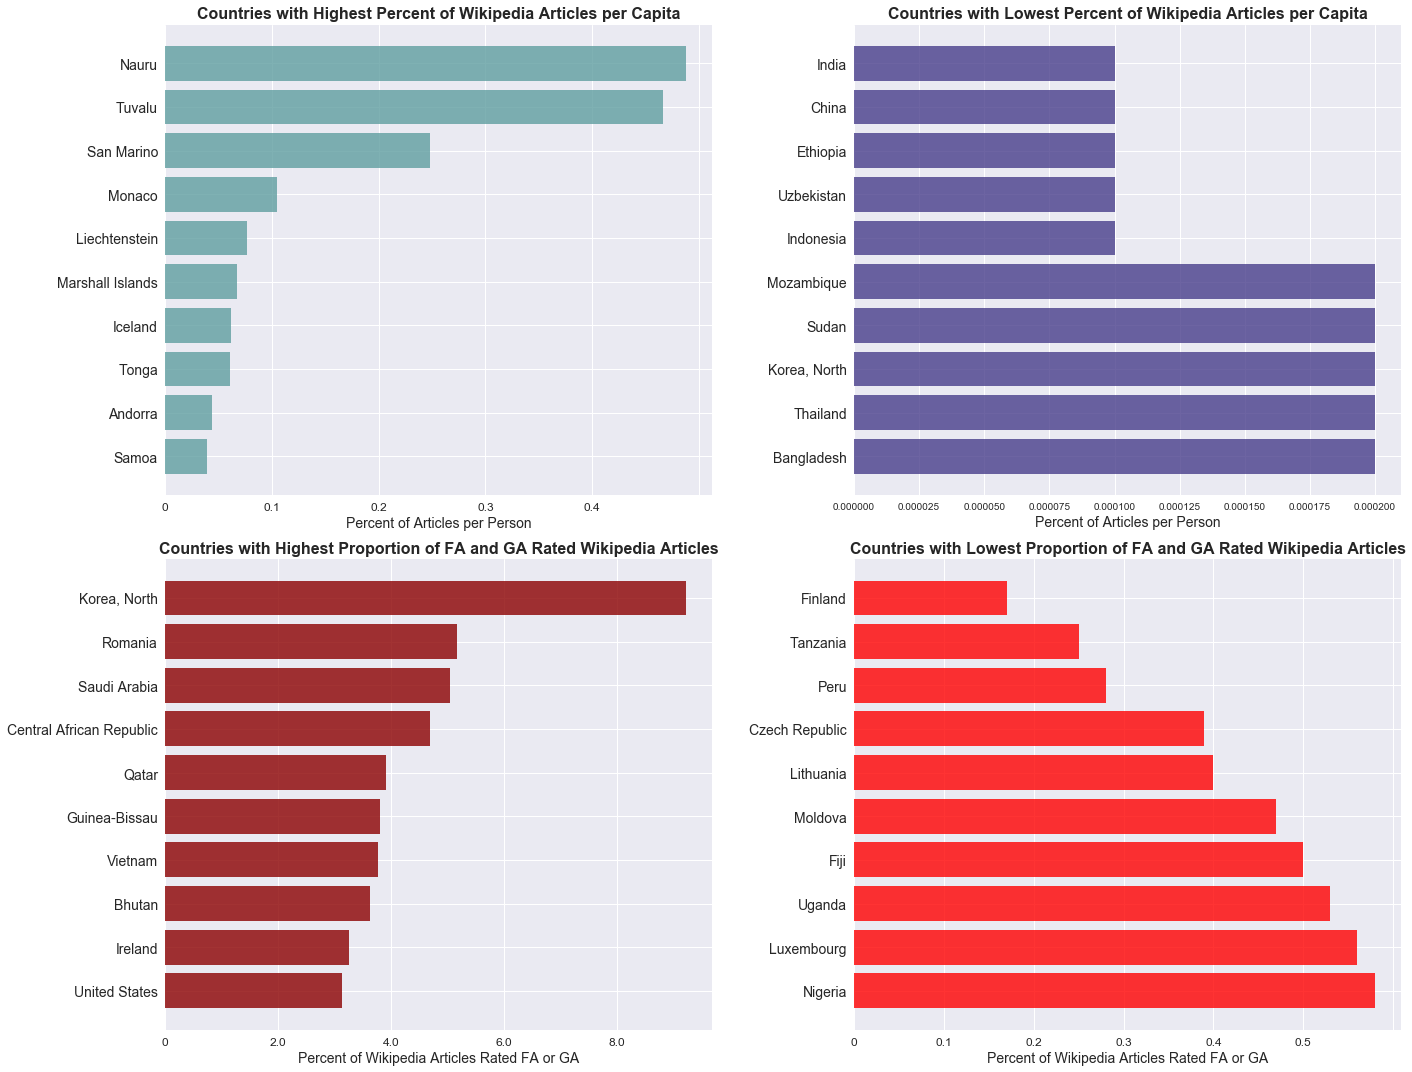

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from textwrap import wrap

# based on example from http://matplotlib.org/examples/lines_bars_and_markers/barh_demo.html
#fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(10, 20))
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

top_country = prop_df["country"].head(10)
y_pos = np.arange(len(top_country))
top_percent = prop_df["percent_articles_per_person"].head(10)

#ax.tick_params(axis="y", which='minor', bottom='off')
#ax.minorticks_on()

ax0.barh(y_pos, top_percent, align='center', color="cadetblue", alpha=0.8)
ax0.set_yticks(y_pos)
ax0.set_yticklabels(top_country, fontsize=14)
ax0.invert_yaxis()  # labels read top-to-bottom
ax0.set_xticklabels(labels=[0, 0.1, 0.2, 0.3, 0.4], fontsize=12)
ax0.set_xlabel("Percent of Articles per Person", fontsize=14)
ax0.set_title("Countries with Highest Percent of Wikipedia Articles per Capita",
              fontsize=16, fontvariant="small-caps", fontweight="semibold")

bottom_country = prop_df["country"].tail(10)[::-1]
y_pos_2 = np.arange(len(bottom_country))
bottom_percent = round(prop_df["percent_articles_per_person"].tail(10)[::-1], 5)

ax1.barh(y_pos_2, bottom_percent, align='center',
         color="darkslateblue", alpha=0.8)
ax1.set_yticks(y_pos_2)
ax1.set_yticklabels(bottom_country, fontsize=14)
ax1.invert_yaxis()
ax1.set_xlabel("Percent of Articles per Person",
               fontsize=14, fontstretch="semi-condensed")
ax1.set_title("Countries with Lowest Percent of Wikipedia Articles per Capita",
              fontsize=16, fontweight="semibold")

top_FA_GA_country = sort_prop_type_df["country"].head(10)
y_pos_3 = np.arange(len(top_FA_GA_country))
top_FA_GA_prop = sort_prop_type_df["percent_FA_GA"].head(10)

ax2.barh(y_pos_3, top_FA_GA_prop, align='center',
         color="darkred", alpha=0.8)
ax2.set_yticks(y_pos_3)
ax2.set_yticklabels(top_FA_GA_country, fontsize=14)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_xticklabels(labels=[0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0],
                    fontsize=12)
ax2.set_xlabel("Percent of Wikipedia Articles Rated FA or GA",
               fontsize=14, fontstretch="semi-condensed")
ax2.set_title("Countries with Highest Proportion of FA and GA Rated Wikipedia Articles",
              fontsize=16, fontweight="semibold")

bottom_FA_GA_country = sort_prop_type_df["country"].tail(10)[::-1]
y_pos_4 = np.arange(len(bottom_FA_GA_country))
bottom_FA_GA_prop = sort_prop_type_df["percent_FA_GA"].tail(10)[::-1]

ax3.barh(y_pos_4, bottom_FA_GA_prop, align='center',
         color="red", alpha=0.8)
ax3.set_yticks(y_pos_4)
ax3.set_yticklabels(bottom_FA_GA_country, fontsize=14)
ax3.invert_yaxis()  # labels read top-to-bottom
ax3.set_xticklabels(labels=[0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=12)
ax3.set_xlabel("Percent of Wikipedia Articles Rated FA or GA",
               fontsize=14, fontstretch="semi-condensed")
ax3.set_title("Countries with Lowest Proportion of FA and GA Rated Wikipedia Articles",
              fontsize=16, fontweight="semibold",
              fontstretch="semi-condensed")

plt.tight_layout()

plt.show()

# Save plot to file
fig.savefig("WikipediaBiasDataPlot.png")

## Writeup

You are also expected to write a short reflection on the project, that describes how this assignment helps you understand the causes and consequences of bias on Wikipedia.  

Write a few paragraphs, either in the README or in the notebook, reflecting on what you have learned, what you found, what (if anything) surprised you about your findings, and/or what theories you have about why any biases might exist (if you find they exist).  

You can also include any questions this assignment raised for you about bias, Wikipedia, or machine learning.  

### Submission instructions
 1.	Complete your Notebook and datasets in Jupyter Hub.  
 2.	Create the data-512-a2 repository on GitHub w/ your code and data.  
 3.	Complete and add your README and LICENSE file.  
 4.	Submit the link to your GitHub repo to: https://canvas.uw.edu/courses/1174178/assignments/3876068
 
### Required deliverables
A directory in your GitHub repository called data-512-a2 that contains the following files:  
 1.	1 final data file in CSV format that follows the formatting conventions.  
 2.	1 Jupyter notebook named hcds-a2-bias that contains all code as well as information necessary to understand each programming step, as well as your writeup (if you have not included it in the README).  
 3.	1 README file in .txt or .md format that contains information to reproduce the analysis, including data descriptions, attributions and provenance information, and descriptions of all relevant resources and documentation (inside and outside the repo) and hyperlinks to those resources, and your writeup (if you have not included it in the notebook).  
 4.	1 LICENSE file that contains an MIT LICENSE for your code.  
 5.	1 .png or .jpeg image of your visualization.
